# Proteomic Analyses Continued

This document will take you through plotting proteomic data.

## (0) Setup

1. Set your working director.
2. Import cptac, numpy (np), and pandas (pd).
3. Download the Brca dataset
4. Extract the clinical, transcriptomic, and proteomic dataframes from the Brca object

In [1]:
# set your working director to analysis data
import os
os.chdir('/Users/kathykliu/Desktop/qbio_490_kailin/analysis_data')

# import cptac, numpy, and pandas
import cptac
import numpy as np
import pandas as pd

# download the Brca dataset
cptac.download(dataset="Brca")
brca = cptac.Brca()

# extract the data
brca.list_data()
clinical_data = brca.get_clinical()
transcriptomic_data = brca.get_transcriptomics()
protein_data = brca.get_proteomics()
protein_data.columns = protein_data.columns.get_level_values(0) 


Below are the dataframes contained in this dataset and their dimensions:

acetylproteomics
	122 rows
	9868 columns
clinical
	122 rows
	18 columns
CNV
	122 rows
	23692 columns
derived_molecular
	122 rows
	36 columns
phosphoproteomics
	122 rows
	38775 columns
proteomics
	122 rows
	10107 columns
somatic_mutation
	24106 rows
	3 columns
transcriptomics
	122 rows
	23121 columns


## (1) Plotting with matplotlib

Let's explore some more complex ways to plot using the Matplotlib package.

Import pyplot from matplotlib as its common handle (plt)

In [2]:
# Write code here
import matplotlib.pyplot as plt

Let's explore how the proteomic expression of a gene differs between young and old patients.

**Exercise 1.1** Plot the expression data of a chosen protein stratified between young ($\lt$50) and old ($\ge$ 50) patients.

In [3]:
#clinical_data
young_mask = clinical_data.loc[:,"Age.in.Month"] < 50*12 # the age column is 'Age.in.Month', which (as stated) is in months
young_mask
old_mask = clinical_data.loc[:,"Age.in.Month"] >= 50*12

#protein_data
young = (protein_data.loc[young_mask,"TP53"]).dropna() 
old = (protein_data.loc[old_mask,"TP53"]).dropna()

data = [old.values, young.values] # our boxplot function will require an array (or an array of arrays)
data

clinical_data


Name,Replicate_Measurement_IDs,Sample_Tumor_Normal,TMT.Plex,TMT.Channel,Stage,Ischemia.Time.in.Minutes,PAM50,NMF.Cluster,NMF.Cluster.Membership.Score,Age.in.Month,Gender,Ethnicity,ER.Updated.Clinical.Status,PR.Clinical.Status,ERBB2.Updated.Clinical.Status,TNBC.Updated.Clinical.Status,ERBB2.Proteogenomic.Status,TOP2A.Proteogenomic.Status
Patient_ID,,,,,,,,,,,,,,,,,,
CPT000814,CPT000814,Tumor,13,127C,Stage IIA,NaN,Basal,Basal-I,1.000,NaN,NaN,black.or.african.american,negative,negative,NaN,positive,negative,negative
CPT001846,CPT001846,Tumor,12,128C,Stage III,NaN,Basal,Basal-I,0.672,NaN,NaN,white,negative,negative,NaN,positive,negative,negative
X01BR001,X01BR001,Tumor,2,129N,Stage IIB,0.0,Basal,Basal-I,0.782,660.0,female,black.or.african.american,negative,negative,negative,positive,negative,negative
X01BR008,X01BR008,Tumor,16,127C,NaN,NaN,Basal,Basal-I,0.958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative,negative
X01BR009,X01BR009,Tumor,16,127N,NaN,NaN,Basal,Basal-I,0.825,NaN,NaN,NaN,negative,negative,NaN,positive,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X21BR001,X21BR001,Tumor,16,128N,NaN,NaN,LumB,LumB-I,0.536,NaN,NaN,white,negative,negative,NaN,negative,positive,negative
X21BR002,X21BR002,Tumor,16,128C,NaN,NaN,LumA,LumB-I,0.443,NaN,NaN,white,positive,positive,NaN,negative,negative,negative
X21BR010,X21BR010|X21BR010.REP1,Tumor,3|17,129C|128C,Stage IIA,18.0,LumA,LumA-I,0.559,852.0,female,white,positive,positive,negative,negative,negative,negative


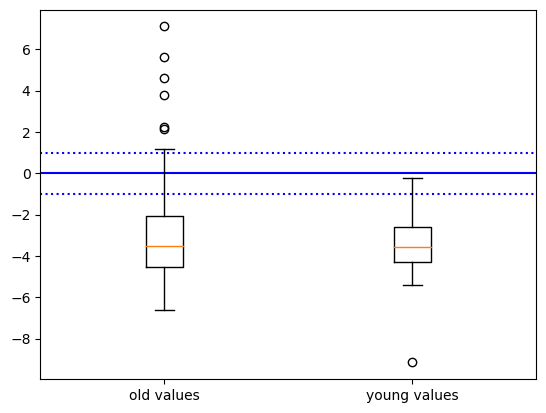

In [4]:
fig, ax = plt.subplots()

plt.axhline(y = 0, color = 'blue', linestyle = '-')
plt.axhline(y = -1, color = 'blue', linestyle = ':')
plt.axhline(y = 1, color = 'blue', linestyle = ':')


bp = ax.boxplot(data) # data goes here
plt.xticks([1, 2], ["old values", "young values"]) # use \n for new line if desired


plt.show()

**Exercise 1.2** Why do you think we added lines at -1, 0, and 1? What do these values represent in terms of log2FoldChange?

In [ ]:
# answer in a comment here
#-1 represents less relative expression (half)
#0 represents no significant difference in relative expression
#1 represents more relative expression (double)

## (2) SciPy

Another question to ask is if the levels of RNA expression correlate with protein expression. While we would expect for there to be a 1:1 relationship between RNA and protein (according to the central dogma), as you will see, this is not what we oftentimes observe.

In [5]:
from scipy import stats # we are using the stats package in particular

The first thing we need to do is to identify which patients and genes are shared between the transcriptomic and proteomic data sets.

Luckily for us, all 122 patients in the Brca dataset have clinical, transcriptomic, and proteomic data. If this were not the case (such as in the colon cancer database), we would use `intersect1d()` to fix this. We will still need to use `intersect1d()` to determine which genes are shared.

**Exercise 2.1** To make sure the data frames match:

1. Identify the names of the genes that are shared between the two datasets (hint: use `intersect1d()`). Is this data the row or column names?
2. Create the rna_shared and prot_shared data frames; ie dataframes with only genes that are shared between rna and protein data. (Hint: how can we access rows/columns by name?).

In [6]:
# 1. Identify the genes (RNA, protein) shared between the two data sets 

#transcriptomic_data
shared_rna_prot = np.intersect1d(transcriptomic_data.columns,protein_data.columns)
shared_rna_prot

# 2. Create the two data frames
rna_shared = transcriptomic_data.loc[:,shared_rna_prot]
rna_shared
prot_shared = protein_data.loc[:,shared_rna_prot]
prot_shared

Name,A1BG,A2M,A2ML1,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,AAMDC,...,ZSCAN31,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Patient_ID,,,,,,,,,,,,,,,,,,,,,
CPT000814,-0.6712,-0.2075,2.7959,1.3969,-1.0899,NaN,1.6708,-0.3484,-0.4756,-0.7299,...,-5.2868,-0.6536,0.3384,2.1169,1.3910,-2.1230,0.9136,-0.8082,-1.4793,0.9136
CPT001846,1.3964,1.3302,-5.0948,0.7674,-1.6845,NaN,2.1022,-0.5814,0.2916,-2.2857,...,-0.7592,0.4711,0.6018,0.2062,-0.2137,-2.1219,0.0860,2.5814,-0.2852,-0.1074
X01BR001,2.0219,1.6269,-3.2943,0.3352,-1.0739,1.2255,0.2754,-1.1187,-0.0534,-0.2519,...,NaN,0.2306,-0.3010,0.3395,-0.5316,NaN,0.4996,0.7622,-1.5607,0.0256
X01BR008,-0.5290,0.3267,1.4342,0.4938,-2.8676,NaN,NaN,-1.0691,-0.3643,-1.8173,...,-2.1789,0.2695,0.1506,1.0498,0.7546,1.7889,-0.2499,-0.2590,-0.1263,0.3725
X01BR009,1.2556,3.4489,2.8043,-0.2956,-1.7261,NaN,NaN,-2.0471,-0.3547,-0.8298,...,-2.3990,-0.2596,0.1898,-0.5010,-0.4189,0.3080,0.5057,0.2181,-0.2288,-0.2750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X21BR001,-0.6610,-0.6402,-4.8578,1.2319,-1.6491,NaN,NaN,-0.3074,-0.3074,-0.0266,...,-0.2528,0.5090,0.0306,0.4908,-0.5570,2.3864,0.3764,-0.6974,1.3541,1.1123
X21BR002,-1.3735,0.4227,-4.9553,0.6327,-3.1434,NaN,NaN,0.3071,0.7562,-1.6912,...,-3.3351,0.1548,1.0792,-0.6619,-1.4444,-0.3704,0.4909,0.3938,0.2992,-0.3494
X21BR010,1.1583,0.3329,-5.7358,-0.1658,-2.0413,-1.2433,0.9090,-0.2410,0.6717,-0.1651,...,-0.7054,0.2752,0.8850,-2.6704,-0.9444,-1.9717,0.0650,0.6300,-0.0686,0.1798


Now, we can see how correlated the RNA and protein levels are. We'll use Spearman correlation from the stats library, which is `spearmanr()`. 

**Exercise 2.2** Choose a gene and get the Spearman correlation of the rna to protein of that gene.

In [7]:
# we need the nan_policy="omit" to throw out NaN values
corr, pval = stats.spearmanr(rna_shared["TP53"], prot_shared["TP53"], nan_policy="omit")

print(f"The correlation of TP53 is {round(corr, 3)} (p = {round(pval, 10)}).")

The correlation of TP53 is 0.389 (p = 9.5868e-06).


**Exercise 2.3** What is your gene's Spearman correlation? What does that mean mathematically? What could this represent biologically? Look into the literature to see if it corroborates this idea.

In [9]:
# answer in a comment here

# The spearman correlation coefficient is 0.389. 
# Mathematically this means that as the rna_shared value increases, the prot_shared value increases.
# Biologically this indicates that the transcription of TP53 is correlated with expression of the TP53 protein.



## (3) Heatmaps
**Exercise 3.1** A problem arises if we want to compare many correlations. Heatmaps are useful for visualizing a large number of comparisons. To make a heatmap, we'll use the `heatmap()` function from seaborn. Let's do the following:

1. Set up our data frame to hold all comparisons. All you need to do is to access the first 20 gene names.
2. Calculate the correlations for the first 20 genes (just to save time). You'll need to use two for loops.
3. Call `clustermap()` -- this is filled in for you!
4. Interpret the data. There is a "light" diagonal along the heatmap from the top-left to bottom-right. Is this expected? Why or why not?

In [10]:
# import seaborn as sns
import seaborn as sns

/Users/kathykliu/opt/miniconda3/envs/qbio490_kailin/lib/python3.9/site-packages/matplotlib/colors.py:1253: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
/Users/kathykliu/opt/miniconda3/envs/qbio490_kailin/lib/python3.9/site-packages/matplotlib/colors.py:1253: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


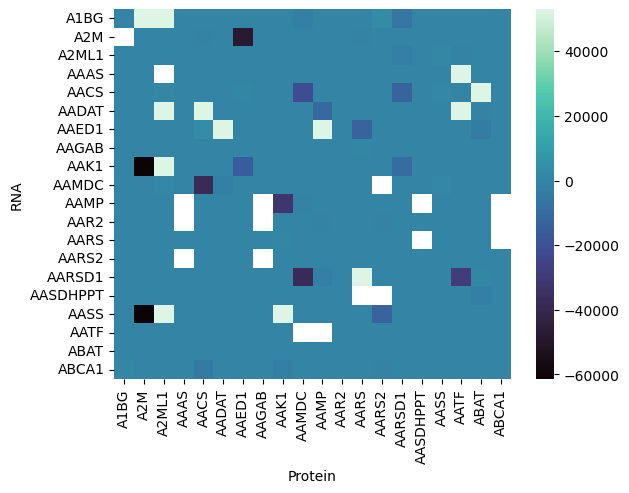

In [11]:
ncomparisons = 20 # define this variable in case we want to change the number of correlations to test
                  # this makes it less likely you'll forget to change a number, e.g. in the data frame shape
gene_names = shared_rna_prot[0:20] # get the first ncomparisons gene names


# Don't worry about this code
# It's good practice to declare your data frame beforehand (it's much faster than appending to a list)
# We fill everything in with 0 just as a placeholder
corr_df = pd.DataFrame(np.ndarray(shape=(ncomparisons, ncomparisons), dtype=np.float16),
                      index = gene_names,
                      columns = gene_names)

# 2. fill in the data frame!
for g1 in gene_names:
    for g2 in gene_names:
        # calculate the correlations between protein and RNA
        # then, use .loc[] to store the correlation in corr_df
        corr ,pval = stats.spearmanr(rna_shared[g1],prot_shared[g2],nan_policy="omit")
        corr_df.loc[g1,g1] = corr

# 3. create the heat map
plot = sns.heatmap(
    corr_df,
    cmap='mako',
)
plot.set_xlabel('Protein', fontsize=10)
plot.set_ylabel('RNA', fontsize=10)
plt.show()

# 4. interpret!
# In the heatmap, the lighter the color, the more positively correlated the RNA and protein are
# Therefore, a light diagonal indicates that the proteins that the RNA genes code for are expressed
# This is expected because the RNA genes are labelled according to which protein they are supposed to produce


## (4) Plotting with Seaborn

`seaborn` is a nice package that makes prettier plots with more control over the figure.

Here's how you make a scatter plot with seaborn, for example:

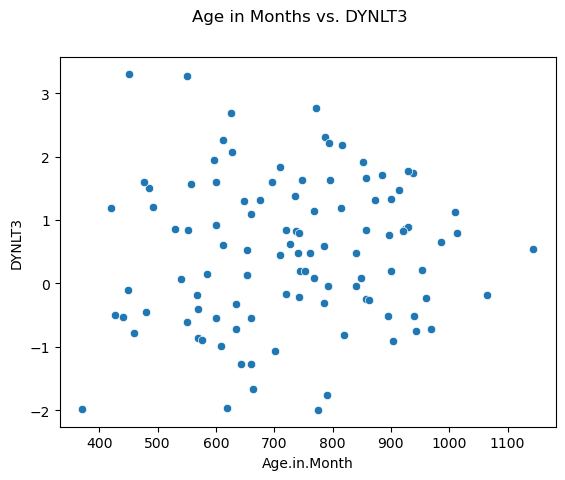

In [12]:
fig, ax = plt.subplots()

sns.scatterplot( # x-axis
    x = clinical_data.loc[:, "Age.in.Month"],
    y = protein_data.loc[:, "DYNLT3"],# y-axis
    legend = "full",  # show the legend
    ax = ax  # necessary for when plotting more than 1 subplot
)

fig.suptitle('Age in Months vs. DYNLT3')  # set title

plt.show()

**Exercise 4.1** Update the above plot to:
1. Have age in years instead of months.
2. Color patients based on gender (or another clinical variable of your choosing)
3. Have a side-by-side second plot with a different protein of your choosing

NOTE: you will need to Google to figure out how to do most of the above things!

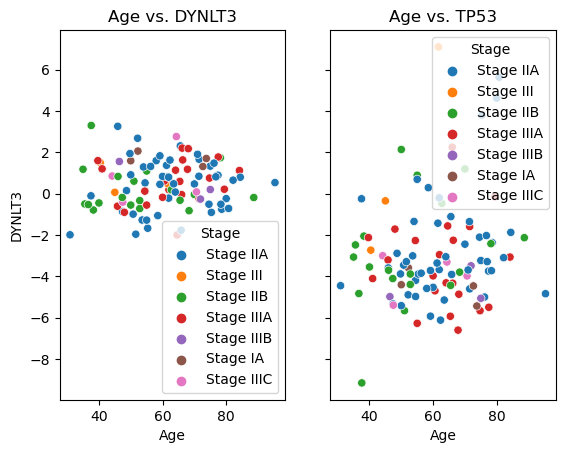

In [13]:
# create plot here

clinical_data["Age"] = clinical_data.loc[:,"Age.in.Month"] / 12

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.scatterplot( # x-axis
    x = clinical_data.loc[:, "Age"],
    y = protein_data.loc[:, "DYNLT3"],# y-axis
    hue= clinical_data.loc[:,"Stage"],
    legend = "full",  # show the legend
    ax = ax1  # necessary for when plotting more than 1 subplot
)

ax1.set_title('Age vs. DYNLT3')  # set title

sns.scatterplot( # x-axis
    x = clinical_data.loc[:, "Age"],
    y = protein_data.loc[:, "TP53"],# y-axis
    hue= clinical_data.loc[:,"Stage"],
    legend = "full",  # show the legend
    ax = ax2  # necessary for when plotting more than 1 subplot
)

ax2.set_title('Age vs. TP53')  # set title

plt.show()

## (5) Saving Plots

Finally, to save a plot, we can call `plt.savefig()` instead of the `plt.show()`.

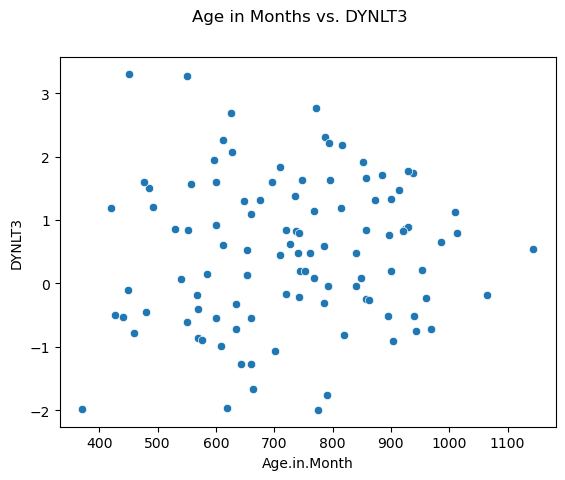

In [14]:
fig, ax = plt.subplots()

sns.scatterplot( # x-axis
    x = clinical_data.loc[:, "Age.in.Month"],
    y = protein_data.loc[:, "DYNLT3"],# y-axis
    legend = "full",  # show the legend
    ax = ax  # necessary for when plotting more than 1 subplot
)

fig.suptitle('Age in Months vs. DYNLT3')  # set title

# age_scatter.png is a relative path so check your working directory before running it
plt.savefig('age_DYNLT3_scatter.png', bbox_inches='tight')